In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne 
from tqdm import tqdm
import scipy.signal as sp_signal
from sktime.libs.vmdpy import VMD
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.signal import periodogram
from pymultifracs.viz import plot_psd
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "scripts")))
from simulation import generate_synthetic_neural_signal
from decomposition import run_all_decompositions
from plotting import plot_signal_and_modes
from features import compute_features_from_modes_and_save
from mfa_utils import compute_mfa, plot_mfa, plot_psd, analyze_signal_and_modes
from evaluation import summarize_decomposition_results
from pymultifracs import mfa, wavelet_analysis


In [2]:
%matplotlib inline

## 1. Signal exploration

In [3]:
def load_signal(path):
    raw = mne.io.read_raw_fif(path, preload=True)
    raw_meg = raw.copy().pick('meg')  
    data = raw_meg.get_data(return_times=False)
    return raw, data

In [4]:
#raw = mne.io.read_raw_fif("../data/sub-01_ses-01_task-rest_proc-filt_raw.fif")
raw, data_matrix = load_signal("../data/sub-01_ses-01_task-rest_proc-filt_raw.fif")


Opening raw data file ../data/sub-01_ses-01_task-rest_proc-filt_raw.fif...
    Range : 34500 ... 116999 =    138.000 ...   467.996 secs
Ready.
Reading 0 ... 82499  =      0.000 ...   329.996 secs...


In [5]:
raw

<Raw | sub-01_ses-01_task-rest_proc-filt_raw.fif, 356 x 82500 (330.0 s), ~224.6 MiB, data loaded>

Using matplotlib as 2D backend.


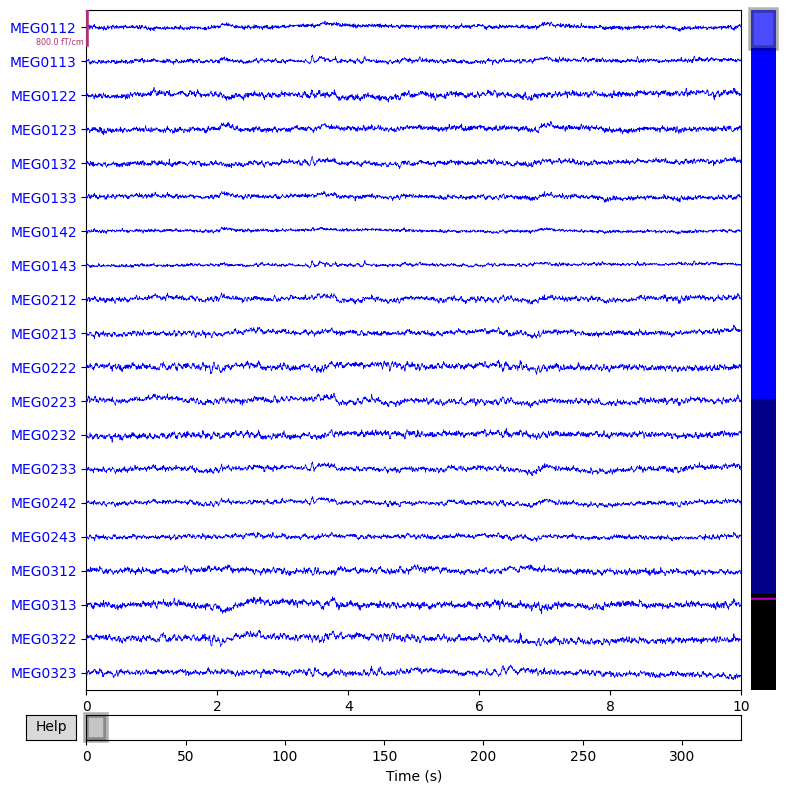

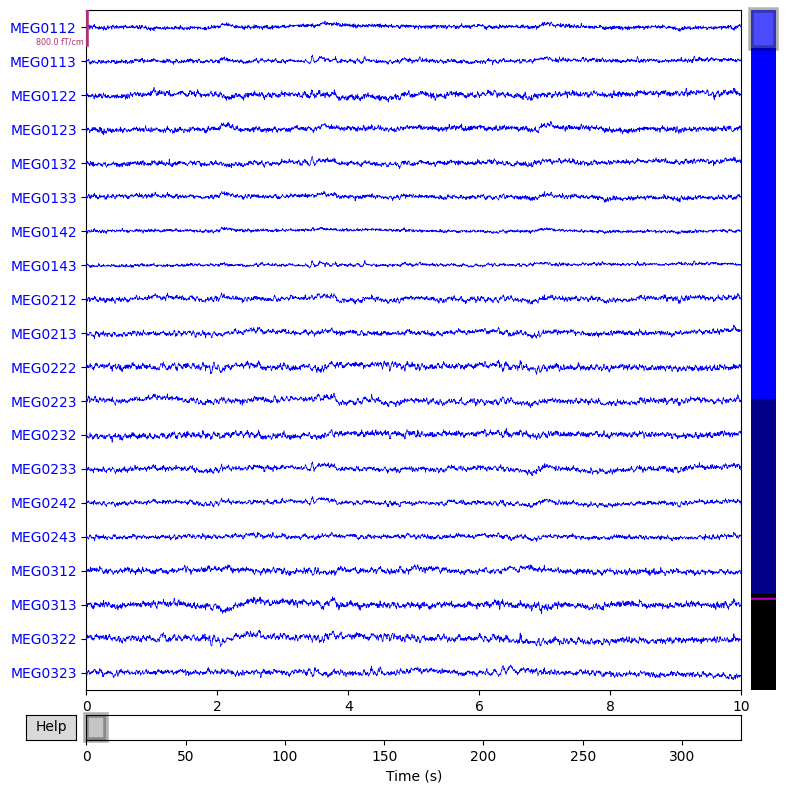

In [6]:
raw.plot()

In [7]:
print(data_matrix.shape)
type(data_matrix)

(306, 82500)


numpy.ndarray

In [8]:
sfreq = raw.info["sfreq"]
sfreq

250.0

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


/opt/homebrew/Caskroom/miniconda/base/envs/mfa-internship/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


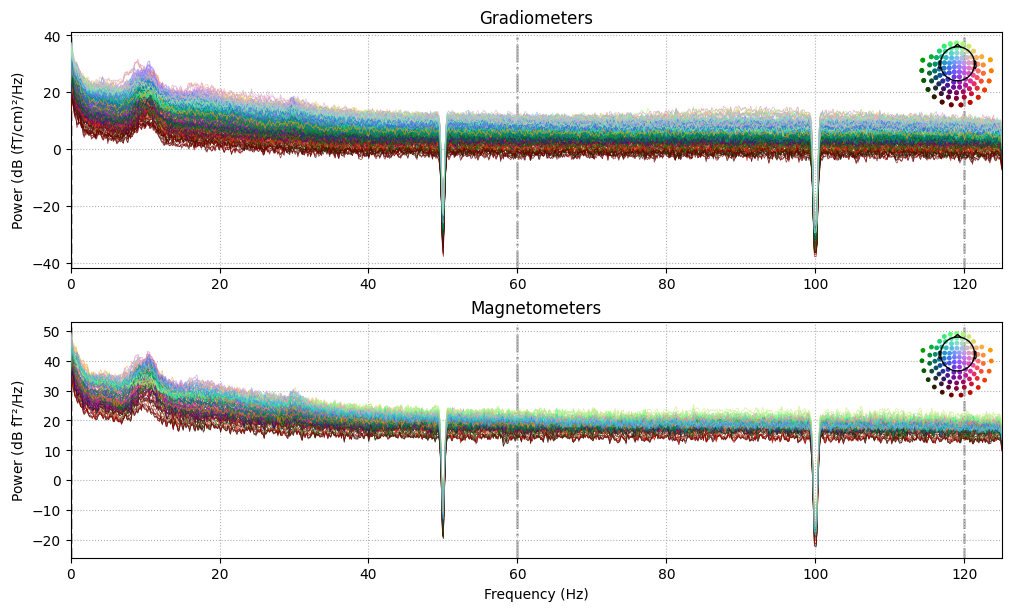

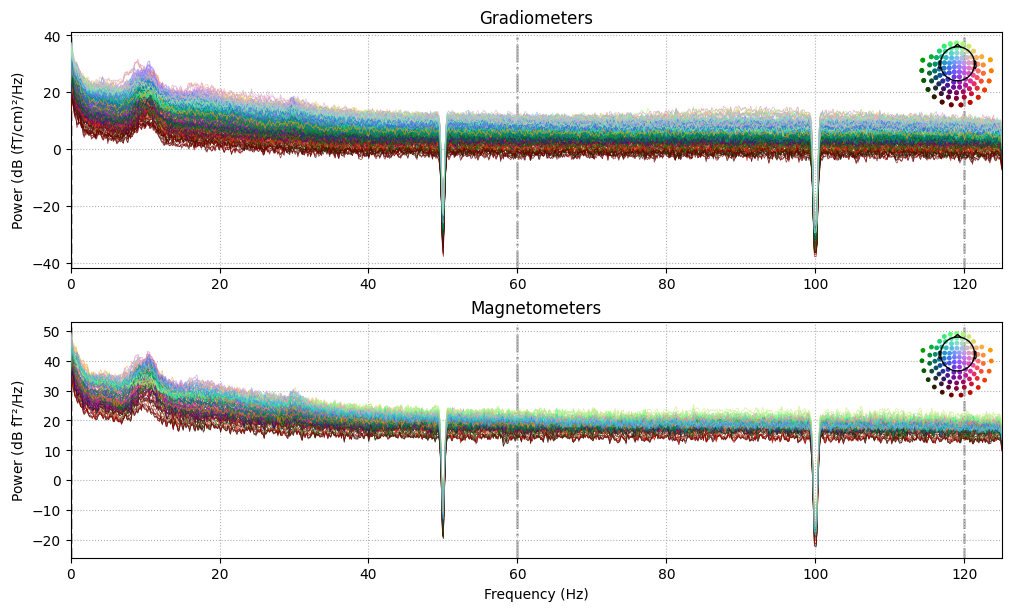

In [9]:
raw.plot_psd()

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).


/opt/homebrew/Caskroom/miniconda/base/envs/mfa-internship/lib/python3.10/site-packages/mne/viz/utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


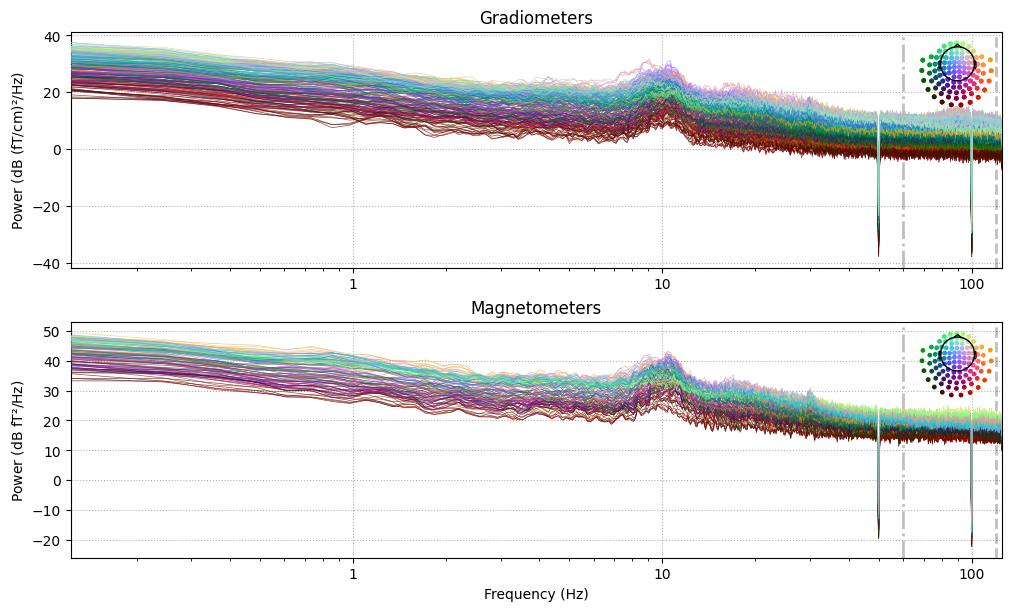

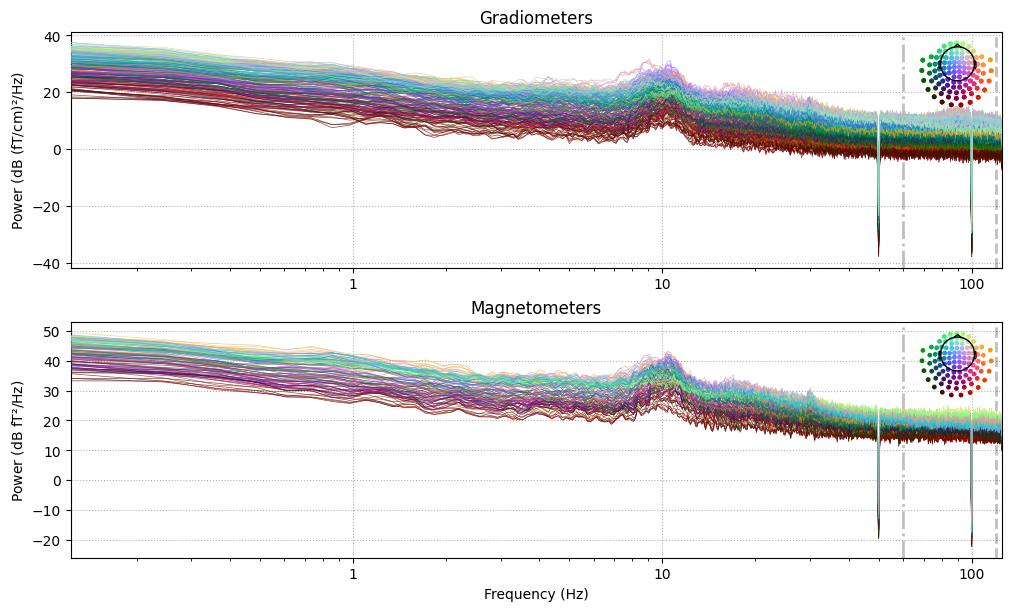

In [10]:
raw.plot_psd(xscale="log")

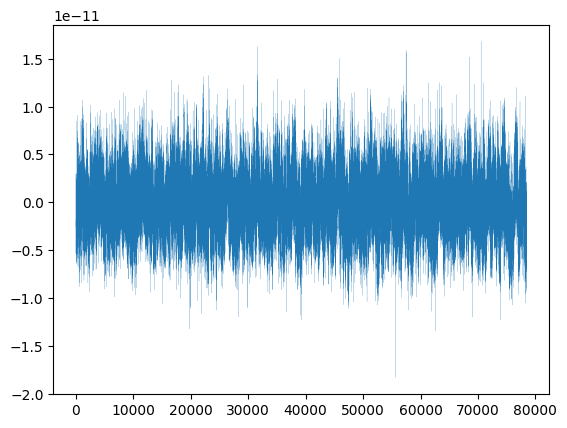

In [11]:
X = data_matrix[2, 2000:-2000]
plt.plot(X, lw=.1)
plt.show()

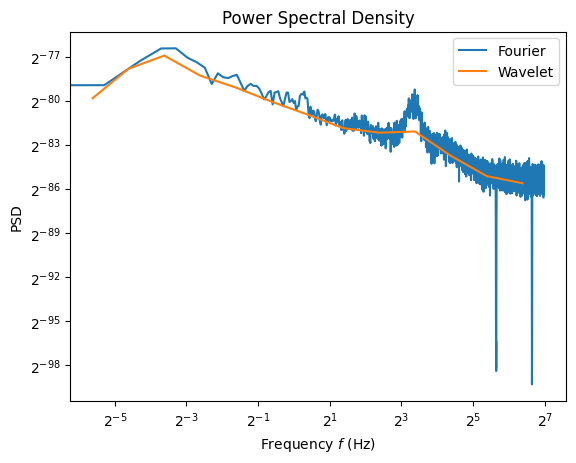

In [12]:
from pymultifracs.viz import plot_psd
plot_psd(X, fs=sfreq)

In [13]:
WT = wavelet_analysis(X, 'db6').integrate(1)

In [14]:
WT.freq2scale(2.0, sfreq)
WT.scale2freq(9, sfreq)

np.float64(0.35511363636363635)

In [15]:
dwt = mfa(WT, [(6, 11)])

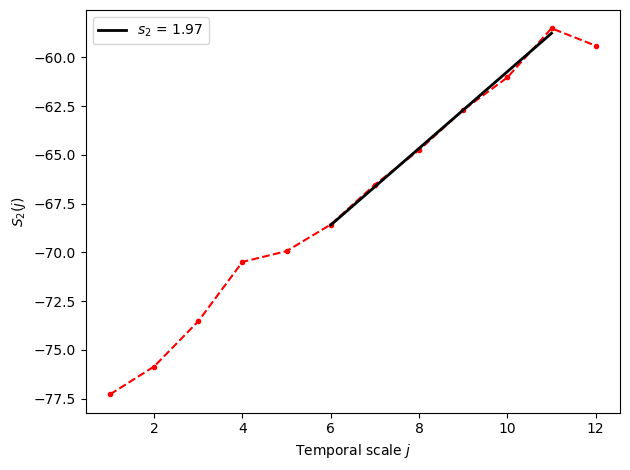

In [16]:
dwt.structure.plot()

In [17]:
H = float(dwt.structure.H.squeeze())

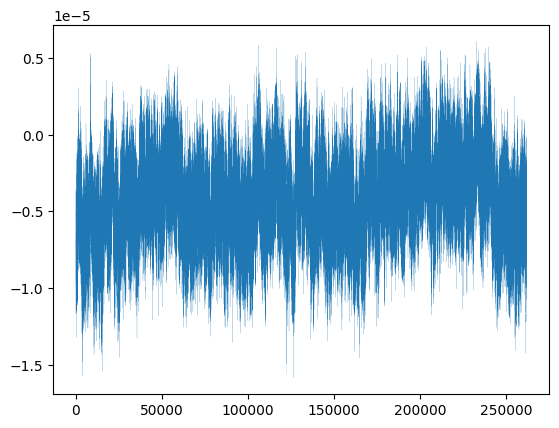

In [18]:
from pymultifracs.simul import fbm
Y = fbm(shape=(2 ** 18), H=H)
plt.plot(np.diff(Y), lw=.1)

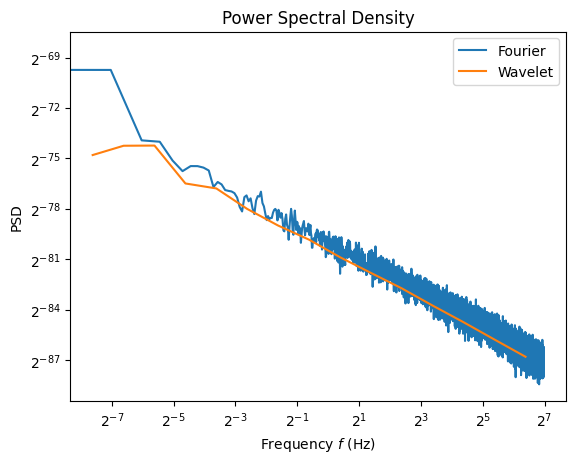

In [19]:
from pymultifracs.viz import plot_psd
plot_psd(np.diff(Y) / np.diff(Y).std() * X.std(), sfreq)


(1.6155871338926322e-27, 1.0587911840678754e-22)

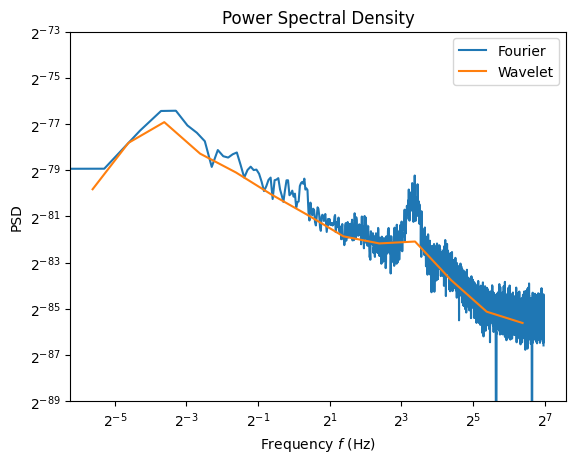

In [20]:
plot_psd(X, sfreq)
plt.ylim(2**-89,2**-73)

## 2. Signal decomposition

### Set General Parameters:

In [5]:
# Parameters (from your code)
fs = 250  # Sampling frequency
duration = 300.0  # Duration to plot (seconds)
max_points = 1000
methods = ["VMD"]

### Run Benchmark:

In [ ]:
# === Overlap Index ===
def spectral_overlap_index(mode1, mode2, fs):
    f1, Pxx1 = periodogram(mode1, fs=fs)
    f2, Pxx2 = periodogram(mode2, fs=fs)
    if not np.allclose(f1, f2):
        raise ValueError("Frequency bins do not match.")
    num = np.sum(np.minimum(Pxx1, Pxx2))
    den = min(np.sum(Pxx1), np.sum(Pxx2))
    return 0.0 if den == 0 else num / den

def compute_soi_matrix(modes, fs):
    K = len(modes)
    soi = np.zeros((K, K))
    for i in range(K):
        for j in range(K):
            soi[i, j] = spectral_overlap_index(modes[i], modes[j], fs)
    mean_soi = np.mean(soi[np.triu_indices(K, k=1)])
    return soi, mean_soi

# === Benchmark Function ===
def benchmark_vmd(signal, fs, param_grid):
    results = []
    spectra = {}
    
    for params in tqdm(param_grid, desc="Benchmarking VMD"):
        Nm = params['Nmodes']
        alpha = params['alpha']
        tau = params['tau']
        DC = params.get('DC', 0)
        init = params.get('init', 1)
        tol = params.get('tol', 1e-6)
        
        modes, _, _ = VMD(signal, alpha, tau, Nm, DC, init, tol)            
        reconstructed = np.sum(modes, axis=0)
        mae = mean_absolute_error(signal, reconstructed)
        _, mean_soi = compute_soi_matrix(modes, fs)


        results.append({
            "alpha": alpha, "tau": tau, "K": Nm, "DC": DC, "init": init, "tol": tol,
            "MAE": mae, 
            "mean_soi": mean_soi,
        })
        spectra[(alpha, tau, Nm)] = modes
    
    return pd.DataFrame(results), spectra


In [ ]:
# === Parameters ===
alphas = [0, 200, 500, 1000, 5000, 10000, 100000, 1000000]
taus = [0, 0.5, 1]
Nmodes_list = [4, 5, 6]
n_channels_to_process = 10  

# === Build parameter grid ===
param_grid = [
    {'Nmodes': k, 'alpha': a, 'tau': t, 'DC': 1, 'init': 1, 'tol': 1e-6}
    for k, a, t in product(Nmodes_list, alphas, taus)
]

# === Load multi-channel MEG signal ===
signal = load_signal("../data/sub-01_ses-01_task-rest_proc-filt_raw.fif")

# === Benchmark VMD ===
all_results = []

for ch in range(n_channels_to_process):
    sig = signal[ch]
    sig = (sig - np.mean(sig)) / np.std(sig)

    print(f"\nBenchmarking channel {ch}")
    df_results, _ = benchmark_vmd(sig, fs, param_grid)
    df_results["channel"] = ch
    all_results.append(df_results) 

# === Save ===
df_all = pd.concat(all_results, ignore_index=True)
df_all.to_csv("benchmark_vmd_first10_channels.csv", index=False)
print("Results saved to benchmark_vmd_first10_channels.csv")

Results saved to benchmark_vmd_first10_channels.csv


In [462]:
df_all["score"] = df_all["MAE"] + df_all["mean_soi"]
df_all = df_all[df_all["alpha"] != 0]

In [463]:
# Best combination per channel
best_per_channel = (
    df_all.loc[df_all.groupby("channel")["score"].idxmin()]
    .sort_values("channel")
    .reset_index(drop=True)
)

# Top 5 global combinations based on alpha + tau
agg = (
    df_all.groupby(["alpha", "tau"])
    .agg(
        mean_MAE=("MAE", "mean"),
        mean_soi=("mean_soi", "mean"),
        score=("score", "mean"),
        n_channels=("channel", "nunique"),
    )
    .reset_index()
    .sort_values("score")
    .head(5)
)

In [464]:
display(best_per_channel)
display(agg)

alpha  tau  K  DC  init       tol       MAE  mean_soi  channel     score
0    200  1.0  6   1     1  0.000001  0.000293  0.019646        0  0.019939
1    200  1.0  6   1     1  0.000001  0.001626  0.020041        1  0.021667
2    200  0.5  6   1     1  0.000001  0.000243  0.020650        2  0.020894

alpha  tau  mean_MAE  mean_soi     score  n_channels
2    200  1.0  0.000721  0.027596  0.028317           3
1    200  0.5  0.006384  0.028292  0.034676           3
5    500  1.0  0.050777  0.027259  0.078036           3
4    500  0.5  0.078541  0.024045  0.102587           3
0    200  0.0  0.088308  0.020869  0.109177           3

### Run the Decompositions:

In [6]:
max_imfs = 5
max_modes = 5
Nmodes = 5
method = "VMD"

best_vmd_params = {
    'meg': {'vmd_alpha': 200, 'vmd_tau': 0.5, 'vmd_DC': 1, 'vmd_init': 0, 'vmd_tol': 1e-7, 'Nmodes': 5},
}

output_base = "../results/real/"
n_channels_to_process = 306 

In [54]:
# Loop through channels
for ch_idx in range(n_channels_to_process):
    # 1. Get the original signal
    signal = data_matrix[ch_idx, :]

    # 2. Standardize manually: zero mean, unit variance
    mean = np.mean(signal)
    std = np.std(signal)
    signal_scaled = (signal - mean) / std

    # 3. Prepare output folder
    name = f"meg_channel_{ch_idx}"
    print(f"--- Decomposition for: {name} ---")
    output_dir = os.path.join(output_base, name)
    os.makedirs(output_dir, exist_ok=True)

    # 4. Get VMD/EMD params
    params = best_vmd_params.get('meg', {})

    # 5. Run all decompositions
    modes_dict = run_all_decompositions(
        signal_in=signal_scaled,
        methods=methods,
        Fs=fs,
        Nmodes=params.get('Nmodes', 3),
        MaxEmdIMF=max_imfs,
        MaxVmdModes=max_modes,
        vmd_alpha=params.get('vmd_alpha', 1),
        vmd_tau=params.get('vmd_tau', 0),
        vmd_DC=params.get('vmd_DC', 1),
        vmd_init=params.get('vmd_init', 0),
        vmd_tol=params.get('vmd_tol', 1e-1),
        return_modes=True
    )

    # 6. Rescale modes back to original signal scale
    for method in modes_dict:
        modes_dict[method] = modes_dict[method] * std + mean

    # 7. Save results
    for method in methods:
        method_dir = os.path.join(output_dir, method)
        os.makedirs(os.path.join(method_dir, "modes"), exist_ok=True)

        np.save(os.path.join(method_dir, "modes", f"{name}_modes.npy"), modes_dict[method])
        print(f"Saved modes for {method} of {name}")

--- Decomposition for: meg_channel_0 ---
VMD decomposition done in 9.83 seconds.
Saved modes for VMD of meg_channel_0
--- Decomposition for: meg_channel_1 ---
VMD decomposition done in 5.62 seconds.
Saved modes for VMD of meg_channel_1
--- Decomposition for: meg_channel_2 ---
VMD decomposition done in 7.00 seconds.
Saved modes for VMD of meg_channel_2
--- Decomposition for: meg_channel_3 ---
VMD decomposition done in 6.34 seconds.
Saved modes for VMD of meg_channel_3
--- Decomposition for: meg_channel_4 ---
VMD decomposition done in 6.71 seconds.
Saved modes for VMD of meg_channel_4
--- Decomposition for: meg_channel_5 ---
VMD decomposition done in 6.94 seconds.
Saved modes for VMD of meg_channel_5
--- Decomposition for: meg_channel_6 ---
VMD decomposition done in 7.72 seconds.
Saved modes for VMD of meg_channel_6
--- Decomposition for: meg_channel_7 ---
VMD decomposition done in 6.37 seconds.
Saved modes for VMD of meg_channel_7
--- Decomposition for: meg_channel_8 ---
VMD decompositi

In [55]:
# Once modes saved, run feature extraction on MEG channels:
for ch_idx in range(n_channels_to_process):
    name = f"meg_channel_{ch_idx}"
    output_dir = os.path.join(output_base, name)
    
    for method in methods:
        modes_path = os.path.join(output_dir, method, "modes", f"{name}_modes.npy")
        features_path = os.path.join(output_dir, method, "features", f"{name}_features.csv")

        compute_features_from_modes_and_save(modes_path, features_path, fs)
        print(f"Features saved for {method} of {name}")


Features saved to ../results/real/meg_channel_0/VMD/features/meg_channel_0_features.csv
Features saved for VMD of meg_channel_0
Features saved to ../results/real/meg_channel_1/VMD/features/meg_channel_1_features.csv
Features saved for VMD of meg_channel_1
Features saved to ../results/real/meg_channel_2/VMD/features/meg_channel_2_features.csv
Features saved for VMD of meg_channel_2
Features saved to ../results/real/meg_channel_3/VMD/features/meg_channel_3_features.csv
Features saved for VMD of meg_channel_3
Features saved to ../results/real/meg_channel_4/VMD/features/meg_channel_4_features.csv
Features saved for VMD of meg_channel_4
Features saved to ../results/real/meg_channel_5/VMD/features/meg_channel_5_features.csv
Features saved for VMD of meg_channel_5
Features saved to ../results/real/meg_channel_6/VMD/features/meg_channel_6_features.csv
Features saved for VMD of meg_channel_6
Features saved to ../results/real/meg_channel_7/VMD/features/meg_channel_7_features.csv
Features saved f

In [8]:
# Generate plots for MEG channels:
for ch_idx in range(n_channels_to_process):
    signal = data_matrix[ch_idx, :] 
    name = f"meg_channel_{ch_idx}"
    output_dir = os.path.join(output_base, name)

    for method in methods:
        modes_path = os.path.join(output_dir, method, "modes", f"{name}_modes.npy")
        
        if not os.path.exists(modes_path):
            print(f"Modes not found for {method} of {name}, skipping.")
            continue
        
        modes = np.load(modes_path)

        plot_signal_and_modes(
            x=signal,
            sfreq=fs,
            modes=modes,
            method=method,
            ch=ch_idx,
            output_dir=output_dir,
            duration=duration,             
            max_points=max_points,        
            spectrum_method='windowed_fft' # or 'psd' or 'fft'
        )
        print(f"Plots saved for {method} of {name}")


Plots saved for VMD of meg_channel_0
Plots saved for VMD of meg_channel_1
Plots saved for VMD of meg_channel_2
Plots saved for VMD of meg_channel_3
Plots saved for VMD of meg_channel_4
Plots saved for VMD of meg_channel_5
Plots saved for VMD of meg_channel_6
Plots saved for VMD of meg_channel_7
Plots saved for VMD of meg_channel_8
Plots saved for VMD of meg_channel_9
Plots saved for VMD of meg_channel_10
Plots saved for VMD of meg_channel_11
Plots saved for VMD of meg_channel_12
Plots saved for VMD of meg_channel_13
Plots saved for VMD of meg_channel_14
Plots saved for VMD of meg_channel_15
Plots saved for VMD of meg_channel_16
Plots saved for VMD of meg_channel_17
Plots saved for VMD of meg_channel_18
Plots saved for VMD of meg_channel_19
Plots saved for VMD of meg_channel_20
Plots saved for VMD of meg_channel_21
Plots saved for VMD of meg_channel_22
Plots saved for VMD of meg_channel_23
Plots saved for VMD of meg_channel_24
Plots saved for VMD of meg_channel_25
Plots saved for VMD of

### Summarize the Results:

Computing inter-mode correlations: 100%|██████████| 306/306 [00:01<00:00, 282.59it/s]


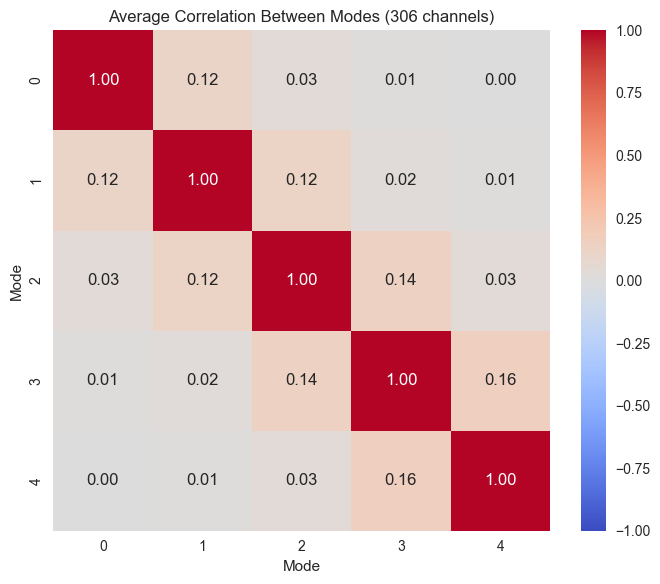

In [92]:
# ---------- STEP 1: Compute correlation matrix for each channel ---------- #
all_corrs = []

for ch in tqdm(range(n_channels_to_process), desc="Computing inter-mode correlations"):
    name = f"meg_channel_{ch}"
    mode_path = os.path.join(output_base, name, method, "modes", f"{name}_modes.npy")

    if not os.path.exists(mode_path):
        print(f"⚠️ Missing: {mode_path}")
        continue

    modes = np.load(mode_path)

    # Ensure shape is (T, Nmodes)
    if modes.shape[0] == Nmodes:
        modes = modes.T  # Now shape: (T, Nmodes)

    # Compute correlation between modes
    corr = np.corrcoef(modes.T)
    all_corrs.append(corr)

# ---------- STEP 2: Average across all channels ---------- #
avg_corr = np.mean(all_corrs, axis=0)

# ---------- STEP 3: Plot ---------- #
plt.figure(figsize=(7, 6))
sns.heatmap(avg_corr, vmin=-1, vmax=1, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Average Correlation Between Modes (306 channels)")
plt.xlabel("Mode")
plt.ylabel("Mode")
plt.tight_layout()
plt.show()


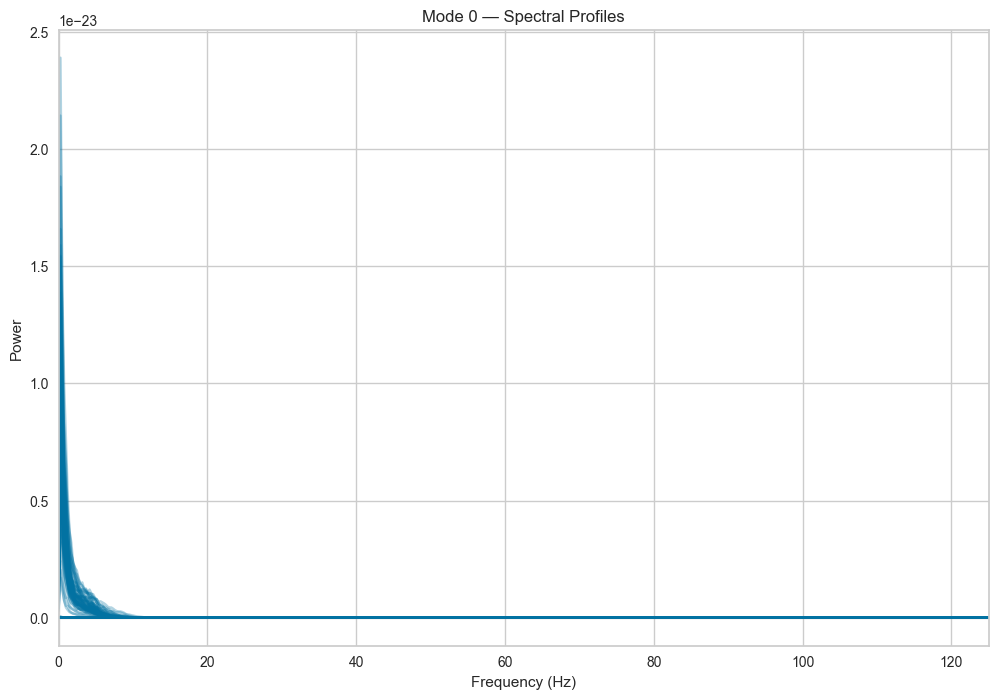

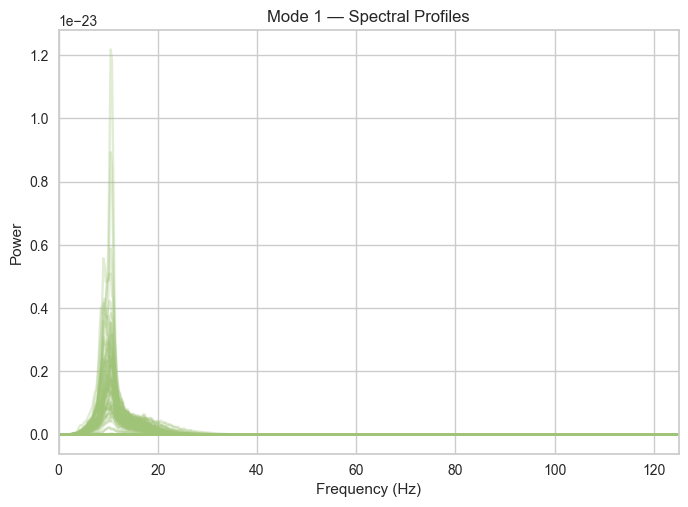

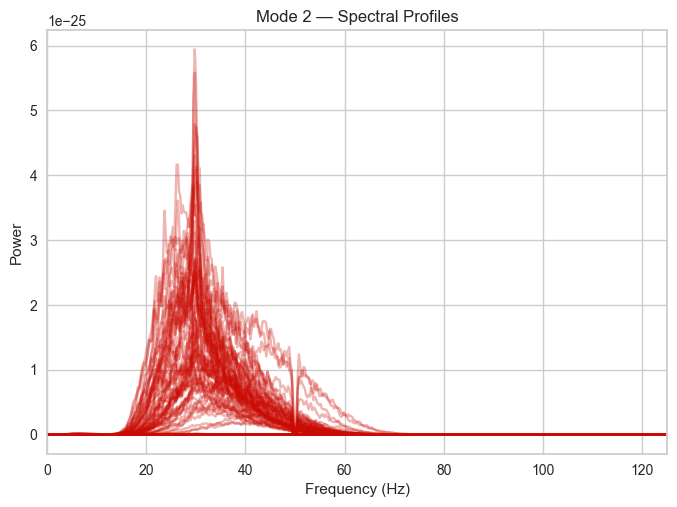

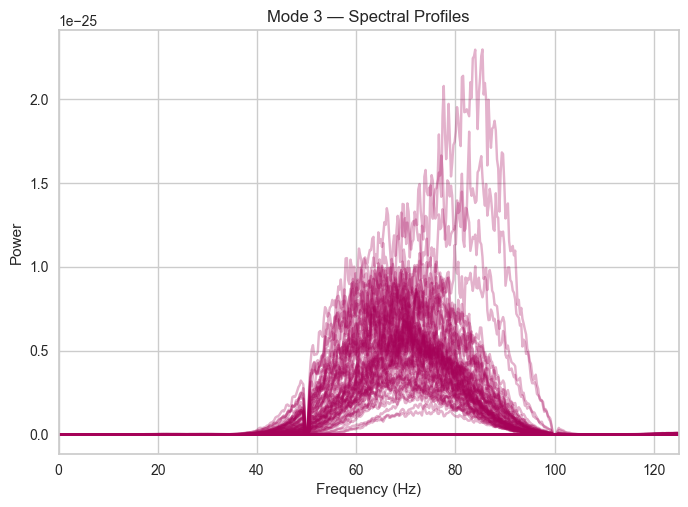

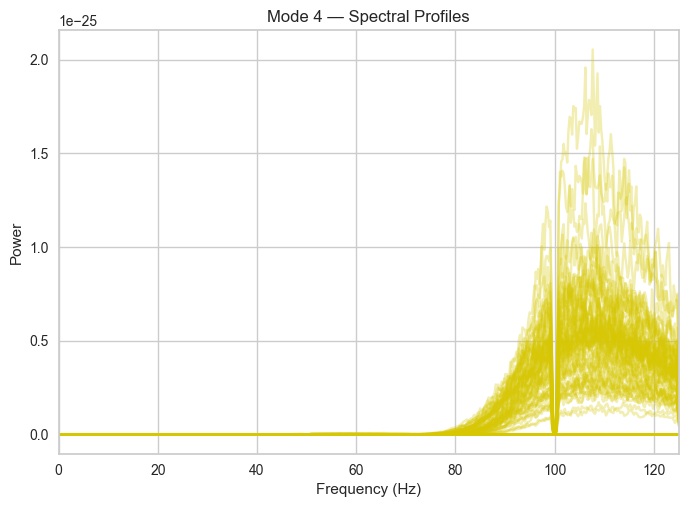

In [99]:
from scipy.signal import welch
import matplotlib.pyplot as plt

Nmodes = 5
n_channels_to_check = 100  # limit for visualization

plt.figure(figsize=(12, 8))

for mode_idx in range(Nmodes):
    for ch in range(n_channels_to_check):
        name = f"meg_channel_{ch}"
        mode_path = os.path.join(output_base, name, method, "modes", f"{name}_modes.npy")
        if not os.path.exists(mode_path):
            continue

        modes = np.load(mode_path)
        signal = modes[mode_idx]

        # Compute power spectral density
        freqs, psd = welch(signal, fs=fs, nperseg=1024)
        plt.plot(freqs, psd, alpha=0.3, label=f"Ch {ch}" if ch == 0 else "", color=f"C{mode_idx}")

    plt.title(f"Mode {mode_idx} — Spectral Profiles")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power")
    plt.xlim(0, fs / 2)
    plt.grid(True)
    plt.show()


In [95]:
features_df.groupby("mode")[["Cent", "Pfreq"]].describe()


Cent                                                            \
      count        mean       std         min         25%         50%   
mode                                                                    
0     306.0    1.503373  0.187622    1.112642    1.369199    1.471241   
1     306.0   12.034850  1.216157    9.847902   11.117918   11.725512   
2     306.0   36.577612  5.604750   25.428463   31.598550   36.590470   
3     306.0   72.602781  4.504207   60.323783   68.956280   73.370483   
4     306.0  108.601007  1.605257  103.826597  107.390434  108.842923   

                              Pfreq                                   \
             75%         max  count        mean       std        min   
mode                                                                   
0       1.599220    2.118466  306.0    0.244141  0.000000   0.244141   
1      12.822785   16.808788  306.0   10.348052  0.719975   8.789062   
2      41.558766   45.885775  306.0   34.616907  6.367554  21.972656   
3      76.396429   81.084349  306.0   72.043824  5.896039  56.152344   
4     110.007970  110.935705  306.0  108.251634  2.890448  99.121094   

                                                      
             25%         50%         75%         max  
mode                                                  
0       0.244141    0.244141    0.244141    0.244141  
1      10.253906   10.498047   10.498047   18.554688  
2      29.785156   30.517578   40.222168   47.607422  
3      67.871094   73.608398   76.416016   85.205078  
4     106.201172  108.398438  109.863281  116.210938

<Axes: >

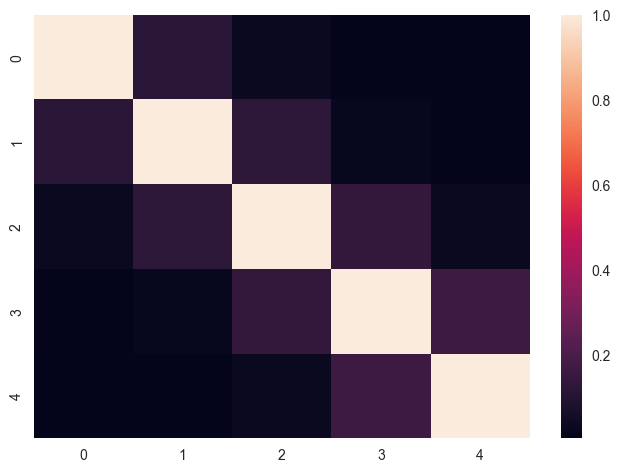

In [96]:
avg_corr = np.mean(all_corrs, axis=0)
sns.heatmap(avg_corr)


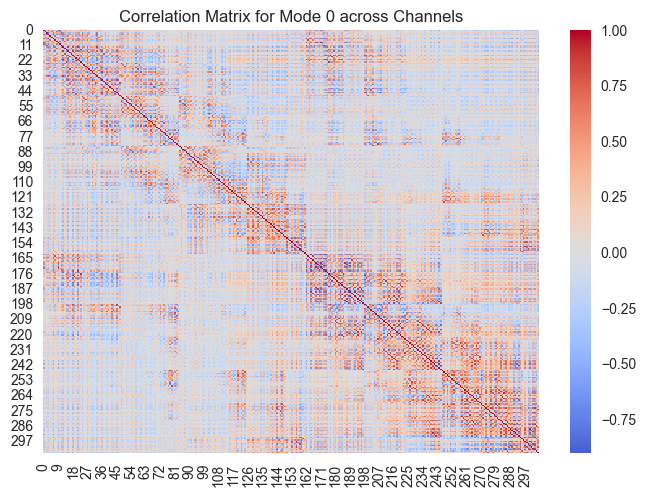

In [97]:
mode_idx = 0
signals = []

for ch in range(n_channels_to_process):
    path = os.path.join(output_base, f"meg_channel_{ch}", method, "modes", f"meg_channel_{ch}_modes.npy")
    if not os.path.exists(path):
        continue
    modes = np.load(path)
    if modes.shape[0] > mode_idx:
        signals.append(modes[mode_idx])

corr_matrix = np.corrcoef(signals)
sns.heatmap(corr_matrix, cmap="coolwarm", center=0)
plt.title(f"Correlation Matrix for Mode {mode_idx} across Channels")
plt.show()


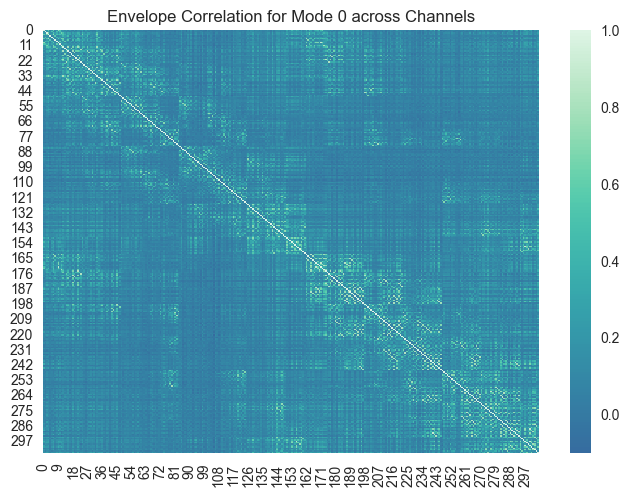

In [98]:
from scipy.signal import hilbert

def envelope(x):
    return np.abs(hilbert(x))

envelopes = [envelope(sig) for sig in signals]
corr_env = np.corrcoef(envelopes)
sns.heatmap(corr_env, cmap="mako", center=0)
plt.title(f"Envelope Correlation for Mode {mode_idx} across Channels")
plt.show()


In [68]:
# ---- Band classifier ----
def get_band(freq):
    if 1 <= freq < 4:
        return "Delta"
    elif 4 <= freq < 8:
        return "Theta"
    elif 8 <= freq < 13:
        return "Alpha"
    elif 13 <= freq <30:
        return "Beta"
    elif 30 <= freq < 80:
        return "Low Gamma"
    elif freq >= 80:
        return "High Gamma"
    else:
        return "NotClassified"

# ---- Rebuild full DataFrame ----
all_rows = []
for ch in range(n_channels_to_process):
    name = f"meg_channel_{ch}"
    feat_path = os.path.join(output_base, name, method, "features", f"{name}_features.csv")
    mode_path = os.path.join(output_base, name, method, "modes", f"{name}_modes.npy")
    
    if not os.path.exists(feat_path) or not os.path.exists(mode_path):
        continue

    df = pd.read_csv(feat_path)
    modes = np.load(mode_path)
    
    for mode_idx in range(Nmodes):
        row = [ch, mode_idx]        
        features = [df[f"{col}{mode_idx}"].iloc[0] for col in ["AM", "BM", "ent", "pow", "Cent", "Ppeak", "Pfreq", "skew", "kurt", "Hmob", "Hcomp"]]
        peak_freq = features[6]  # Ppeak
        band = get_band(peak_freq)
        
        all_rows.append(row + features + [band])

# ---- Final DataFrame ----
columns = ["channel", "mode", "AM", "BM", "ent", "pow", "Cent", "Ppeak", "Pfreq", "skew", "kurt", "Hmob", "Hcomp", "band"]
features_df = pd.DataFrame(all_rows, columns=columns)

In [8]:
features_df.head(10)

channel  mode            AM            BM       ent       pow        Cent  \
0        0     0  1.619430e+16  2.429728e+07  3.818828  0.000231    1.369039   
1        0     1  4.457804e+16  2.854323e+08  5.658255  0.000061   12.134132   
2        0     2  1.773910e+17  9.454348e+08  7.157653  0.000016   40.268168   
3        0     3  1.948175e+17  1.800733e+09  7.260703  0.000014   76.649285   
4        0     4  2.052032e+17  2.465257e+09  7.098242  0.000015  109.202626   
5        1     0  6.625907e+14  2.162701e+07  3.382965  0.000364    1.112642   
6        1     1  4.475517e+15  3.426674e+08  6.346830  0.000032   14.560775   
7        1     2  9.000895e+15  1.053559e+09  7.132222  0.000016   44.751842   
8        1     3  9.281582e+15  1.832917e+09  7.200917  0.000015   77.894244   
9        1     4  9.075425e+15  2.515677e+09  7.012571  0.000016  110.559480   

      Ppeak       Pfreq      skew      kurt      Hmob      Hcomp  \
0  0.243514    0.244141 -0.399276  1.123100  0.054765  11.003011   
1  0.064026   10.253906  0.006512  0.358334  0.320878   1.336926   
2  0.013087   37.597656 -0.002142  0.083966  0.981706   1.073465   
3  0.010912   76.904297  0.001041 -0.002774  1.636510   1.012601   
4  0.010984  108.886719  0.000318  0.095243  1.949135   1.001407   
5  0.364775    0.244141  0.551258  0.677485  0.050326  10.423496   
6  0.037820   10.253906 -0.060833  0.352982  0.390256   1.338413   
7  0.012863   46.630859  0.000970  0.033164  1.075247   1.054482   
8  0.011310   76.416016  0.005321 -0.030569  1.654188   1.010848   
9  0.011535  108.886719  0.000481  0.047283  1.956691   1.001104   

            band  
0  NotClassified  
1          Alpha  
2          Gamma  
3          Gamma  
4     High Gamma  
5  NotClassified  
6          Alpha  
7          Gamma  
8          Gamma  
9     High Gamma

In [15]:
features_df["band"].value_counts()

band
Low Gamma        509
NotClassified    323
Alpha            305
High Gamma       305
Beta              88
Name: count, dtype: int64

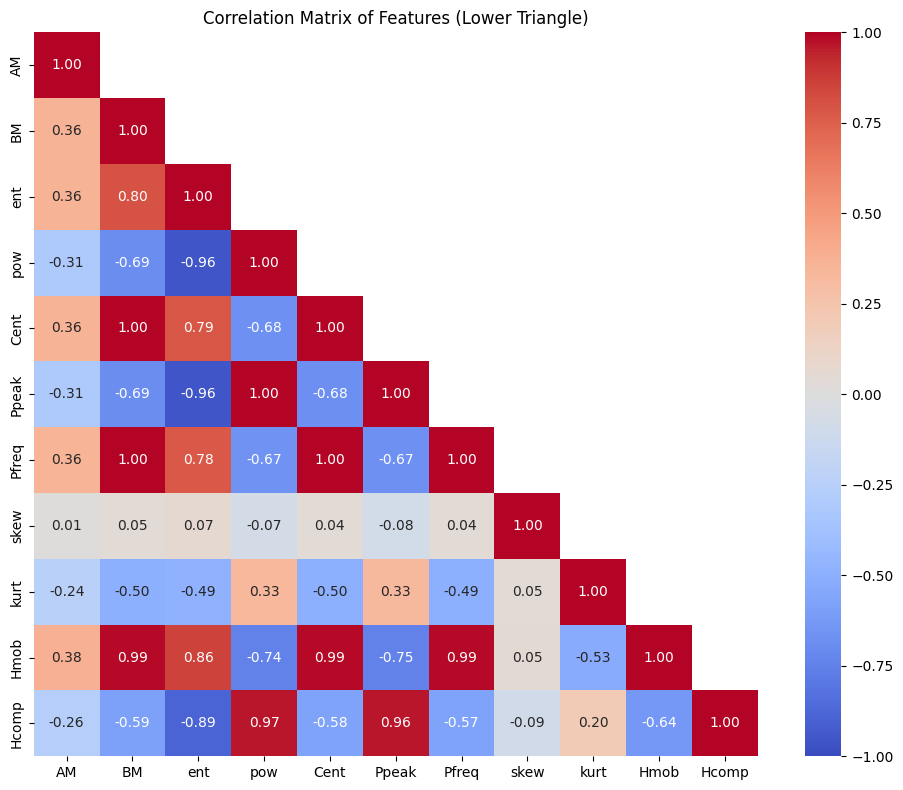

In [11]:
# Compute correlation matrix
corr = features_df.drop(columns=["channel", "mode", "band"]).corr()

# Create mask for the upper triangle (excluding diagonal)
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(corr, 
            vmin=-1, vmax=1, 
            annot=True, fmt=".2f", 
            cmap="coolwarm", 
            mask=mask, square=True)

plt.title("Correlation Matrix of Features (Lower Triangle)")
plt.tight_layout()
plt.show()


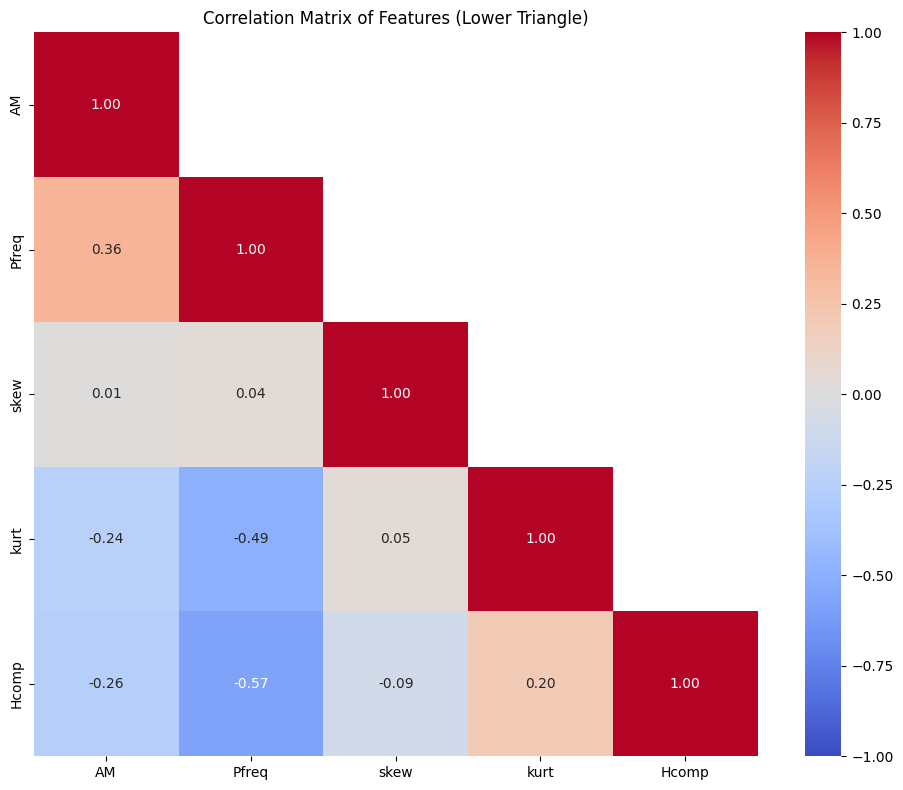

In [12]:
# Compute correlation matrix
corr = features_df.drop(columns=["channel", "mode", "band","BM","ent","pow","Cent","Hmob","Ppeak"]).corr()

# Create mask for the upper triangle (excluding diagonal)
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(corr, 
            vmin=-1, vmax=1, 
            annot=True, fmt=".2f", 
            cmap="coolwarm", 
            mask=mask, square=True)

plt.title("Correlation Matrix of Features (Lower Triangle)")
plt.tight_layout()
plt.show()


In [69]:
features_to_drop =['channel', 'mode', 'AM', 'BM', 'ent', 'pow', 'Cent', 'Ppeak',
       'skew', 'kurt', 'Hmob', 'Hcomp', 'band']

#features_to_drop =['channel', 'mode','band']

X = features_df.drop(columns=features_to_drop)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [70]:
X

Pfreq
0       0.244141
1      10.253906
2      37.597656
3      76.904297
4     108.886719
...          ...
1525    0.244141
1526   10.986328
1527   42.236328
1528   77.636719
1529  108.642578

[1530 rows x 1 columns]

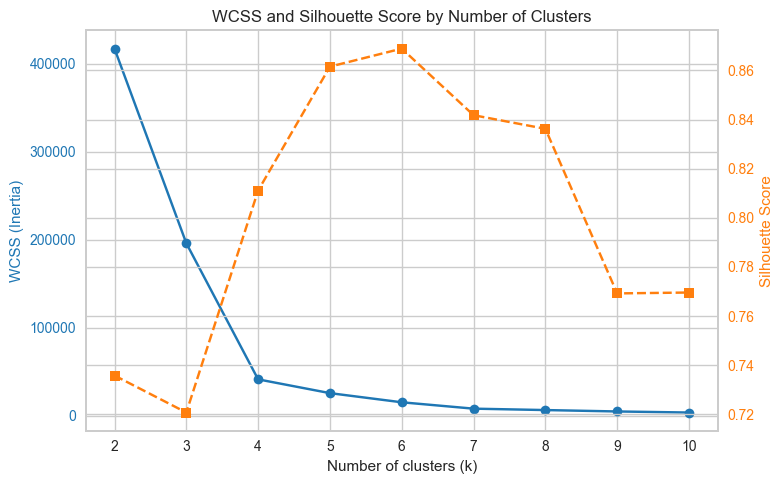

In [71]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# Range of cluster numbers to evaluate
k_range = range(2, 11)

wcss = []
silhouette_scores = []

# Loop over k values to compute WCSS and average Silhouette
for k in k_range:
    model = KMeans(n_clusters=k, random_state=0)
    labels = model.fit_predict(X)
    wcss.append(model.inertia_)  # Within-cluster sum of squares
    silhouette_scores.append(silhouette_score(X, labels))  # Average silhouette score

# Plotting WCSS and Silhouette
fig, ax1 = plt.subplots(figsize=(8, 5))

color1 = 'tab:blue'
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('WCSS (Inertia)', color=color1)
ax1.plot(k_range, wcss, marker='o', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_title("WCSS and Silhouette Score by Number of Clusters")

# Second y-axis for silhouette score
ax2 = ax1.twinx()
color2 = 'tab:orange'
ax2.set_ylabel('Silhouette Score', color=color2)
ax2.plot(k_range, silhouette_scores, marker='s', linestyle='--', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

plt.tight_layout()
plt.show()


In [56]:
pca = PCA(n_components=2)
proj = pca.fit_transform(X_scaled)
features_df["PC1"] = proj[:, 0]
features_df["PC2"] = proj[:, 1]

In [72]:
# KMeans Clustering
kmeans = KMeans(n_clusters=6,init='k-means++',   random_state=42, n_init=100)
features_df["kmeans_cluster"] = kmeans.fit_predict(X_scaled)

# DBSCAN Clustering (Optional Tuning Needed)
dbscan = DBSCAN(eps=0.85, min_samples=50)
features_df["dbscan_cluster"] = dbscan.fit_predict(X_scaled)

# MixtureGaussian Clustering
gaussianmixture = GaussianMixture(n_components=6 , init_params="k-means++")
features_df["gm_cluster"] = gaussianmixture.fit_predict(X_scaled)

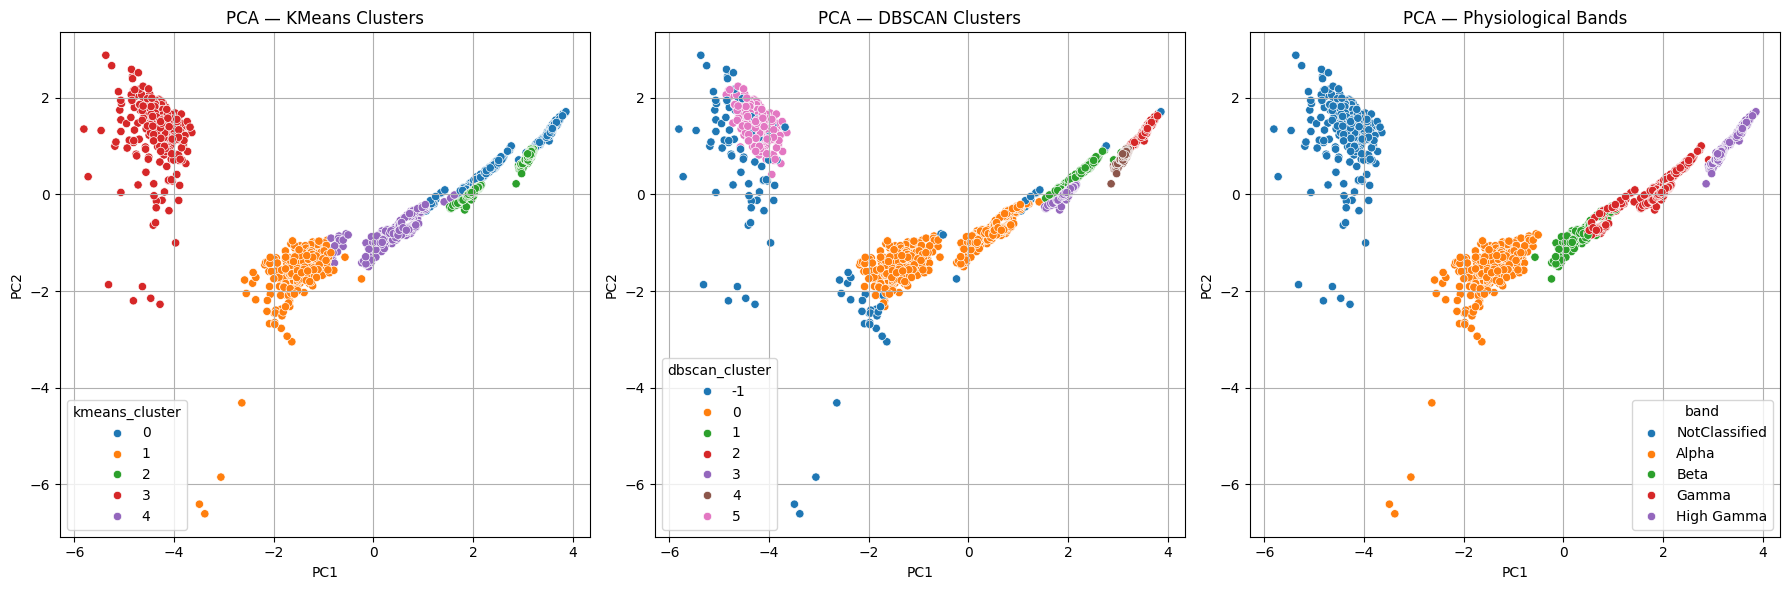

In [58]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

sns.scatterplot(data=features_df, x="PC1", y="PC2", hue="kmeans_cluster", palette="tab10", ax=axs[0])
axs[0].set_title("PCA — KMeans Clusters")

sns.scatterplot(data=features_df, x="PC1", y="PC2", hue="dbscan_cluster", palette="tab10", ax=axs[1])
axs[1].set_title("PCA — DBSCAN Clusters")

sns.scatterplot(data=features_df, x="PC1", y="PC2", hue="band", palette="tab10", ax=axs[2])
axs[2].set_title("PCA — Physiological Bands")

for ax in axs:
    ax.grid(True)
plt.tight_layout()
plt.show()

In [28]:
features_df

channel  mode            AM            BM       ent       pow  \
0           0     0  1.619430e+16  2.429728e+07  3.818828  0.000231   
1           0     1  4.457804e+16  2.854323e+08  5.658255  0.000061   
2           0     2  1.773910e+17  9.454348e+08  7.157653  0.000016   
3           0     3  1.948175e+17  1.800733e+09  7.260703  0.000014   
4           0     4  2.052032e+17  2.465257e+09  7.098242  0.000015   
...       ...   ...           ...           ...       ...       ...   
1525      305     0  9.890172e+14  2.459465e+07  3.973728  0.000209   
1526      305     1  2.496072e+15  2.911765e+08  5.840269  0.000049   
1527      305     2  9.336636e+15  9.687155e+08  7.143784  0.000016   
1528      305     3  1.087823e+16  1.775044e+09  7.268588  0.000014   
1529      305     4  1.119681e+16  2.455662e+09  7.068813  0.000016   

            Cent     Ppeak       Pfreq      skew      kurt      Hmob  \
0       1.369039  0.243514    0.244141 -0.399276  1.123100  0.054765   
1      12.134132  0.064026   10.253906  0.006512  0.358334  0.320878   
2      40.268168  0.013087   37.597656 -0.002142  0.083966  0.981706   
3      76.649285  0.010912   76.904297  0.001041 -0.002774  1.636510   
4     109.202626  0.010984  108.886719  0.000318  0.095243  1.949135   
...          ...       ...         ...       ...       ...       ...   
1525    1.529659  0.227463    0.244141 -0.512417  2.276634  0.057407   
1526   12.386702  0.049080   10.986328  0.058449  0.821177  0.328066   
1527   41.294795  0.012866   42.236328  0.000890  0.026369  1.003138   
1528   75.665607  0.011586   77.636719 -0.014103  0.018117  1.622310   
1529  110.269720  0.011112  108.642578  0.000816  0.014782  1.954452   

          Hcomp           band  kmeans_cluster  dbscan_cluster  gm_cluster  
0     11.003011  NotClassified               4               0           0  
1      1.336926          Alpha               1               0           4  
2      1.073465      Low Gamma               3               0           2  
3      1.012601      Low Gamma               2               0           1  
4      1.001407     High Gamma               0               0           3  
...         ...            ...             ...             ...         ...  
1525  10.562792  NotClassified               4               0           0  
1526   1.334098          Alpha               1               0           4  
1527   1.067189      Low Gamma               3               0           2  
1528   1.013238      Low Gamma               2               0           1  
1529   1.001273     High Gamma               0               0           3  

[1530 rows x 17 columns]

<Axes: xlabel='Pfreq', ylabel='Count'>

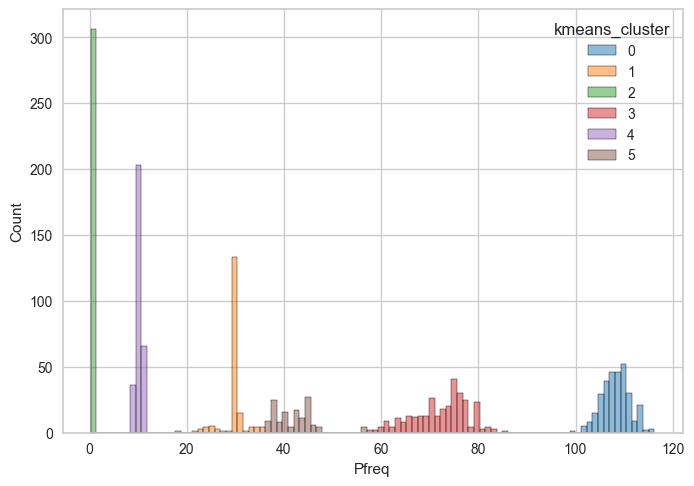

In [73]:
sns.histplot(data=features_df, x='Pfreq',bins=100, hue="kmeans_cluster",palette="tab10")

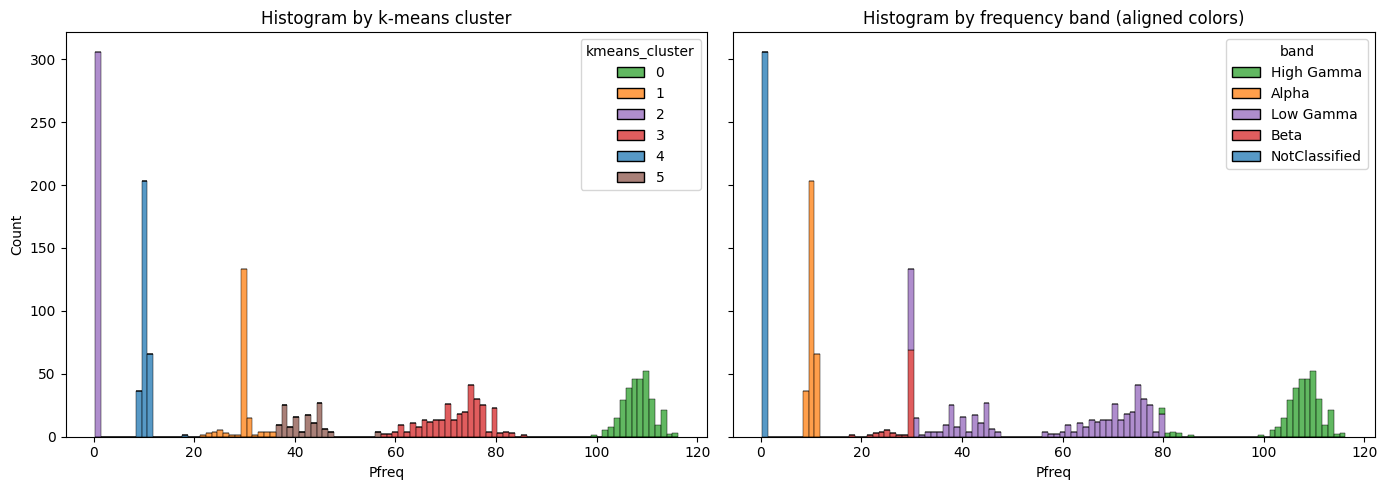

In [ ]:
# Create a 6-color palette to match 6 clusters
colors = sns.color_palette("tab10", n_colors=6)

# Define the mapping between clusters and colors (0–4 mapped to bands, 5 is extra)
cluster_palette = {
    0: colors[2],  # High Gamma
    1: colors[1],  # Alpha
    2: colors[4],  # Low Gamma
    3: colors[3],  # Beta
    4: colors[0],  # NotClassified
    5: colors[5],  # Extra cluster with no band match (e.g., Unknown)
}

# Define matching palette for bands (only the 5 known ones)
band_palette = {
    'High Gamma': colors[2],     # matches cluster 0
    'Alpha': colors[1],          # matches cluster 1
    'Low Gamma': colors[4],      # matches cluster 2
    'Beta': colors[3],           # matches cluster 3
    'NotClassified': colors[0],  # matches cluster 4
}

# Define order
cluster_order = [0, 1, 2, 3, 4, 5]
band_order = ['High Gamma', 'Alpha', 'Low Gamma', 'Beta', 'NotClassified']

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Histogram by cluster (all 6)
sns.histplot(
    data=features_df,
    x='Pfreq',
    hue='kmeans_cluster',
    hue_order=cluster_order,
    bins=100,
    palette=cluster_palette,
    multiple='stack',
    ax=axes[0]
)
axes[0].set_title("Histogram by k-means cluster")

# Histogram by band (only 5)
sns.histplot(
    data=features_df,
    x='Pfreq',
    hue='band',
    hue_order=band_order,
    bins=100,
    palette=band_palette,
    multiple='stack',
    ax=axes[1]
)
axes[1].set_title("Histogram by frequency band (aligned colors)")

plt.tight_layout()
plt.show()


In [56]:
# KMeans vs. band
cont_kmeans = pd.crosstab(features_df["kmeans_cluster"], features_df["band"])
display(cont_kmeans)

# DBSCAN vs. band
cont_dbscan = pd.crosstab(features_df["dbscan_cluster"], features_df["band"])
display(cont_dbscan)

band            Alpha  Beta  High Gamma  Low Gamma  NotClassified
kmeans_cluster                                                   
0                   0     0         306          0              0
1                   0    87           0         92              0
2                   0     0           0          0            306
3                   0     0          16        286              0
4                 305     1           0          0              0
5                   0     0           0        131              0

band            Alpha  Beta  High Gamma  Low Gamma  NotClassified
dbscan_cluster                                                   
0                 305    88         322        509            306

In [ ]:
from scipy.stats import pearsonr


# ------------------- CONFIG ------------------- #
output_base = "../results/real"  # Update path if needed
method = "VMD"                   # Or EMD, MVMD
required_cols = ["channel", "mode", "kmeans_cluster", "band", "signal"]

# ------------------- STEP 1: Load modes_df (if needed) ------------------- #
# If you already have `modes_df`, skip this section.

modes_df = []
n_channels = features_df["channel"].nunique()
for ch in tqdm(range(n_channels), desc="Loading mode files"):
    name = f"meg_channel_{ch}"
    mode_path = os.path.join(output_base, name, method, "modes", f"{name}_modes.npy")
    if not os.path.exists(mode_path):
        print(f"⚠️ File missing: {mode_path}")
        continue

    modes = np.load(mode_path)
    for mode_idx in range(modes.shape[0]):
        match = features_df[(features_df["channel"] == ch) & (features_df["mode"] == mode_idx)]
        if match.empty:
            print(f"⚠️ No match for channel={ch}, mode={mode_idx}")
            continue
        row = match.iloc[0]
        modes_df.append({
            "channel": ch,
            "mode": mode_idx,
            "kmeans_cluster": row["kmeans_cluster"],
            "band": row["band"],
            "signal": modes[mode_idx]
        })

modes_df = pd.DataFrame(modes_df)

Loading mode files: 100%|██████████| 306/306 [00:02<00:00, 147.92it/s]


In [76]:
modes_df

channel  mode  kmeans_cluster           band  \
0           0     0               2  NotClassified   
1           0     1               4          Alpha   
2           0     2               5      Low Gamma   
3           0     3               3      Low Gamma   
4           0     4               0     High Gamma   
...       ...   ...             ...            ...   
1525      305     0               2  NotClassified   
1526      305     1               4          Alpha   
1527      305     2               5      Low Gamma   
1528      305     3               3      Low Gamma   
1529      305     4               0     High Gamma   

                                                 signal  
0     [-5.017583339462216e-14, -5.261014991693875e-1...  
1     [-3.392763350408755e-14, -3.212532714838822e-1...  
2     [6.952042606264245e-14, -1.8615792759994876e-1...  
3     [9.05414761445411e-15, -2.019241516286839e-14,...  
4     [-6.995578392297886e-15, 1.5562886429827452e-1...  
...                                                 ...  
1525  [-2.107894161523428e-12, -2.090995554381574e-1...  
1526  [1.7310367662048646e-12, 1.6802647746594565e-1...  
1527  [-1.0774508228600035e-12, -6.958313998738576e-...  
1528  [1.0840356766338839e-12, -2.3314166700907294e-...  
1529  [7.734314507313517e-14, -4.133494705701508e-13...  

[1530 rows x 5 columns]

In [ ]:
# ------------------- STEP 2: Pivot Table (mode index vs cluster) ------------------- #
pivot = pd.crosstab(modes_df["mode"], modes_df["kmeans_cluster"])
print("Pivot table (mode index vs kmeans cluster):")
display(pivot)

Pivot table (mode index vs kmeans cluster):


kmeans_cluster    0    1    2    3    4    5
mode                                        
0                 0    0  306    0    0    0
1                 0    0    0    0  306    0
2                 0  179    0    0    0  127
3                 0    0    0  302    0    4
4               306    0    0    0    0    0

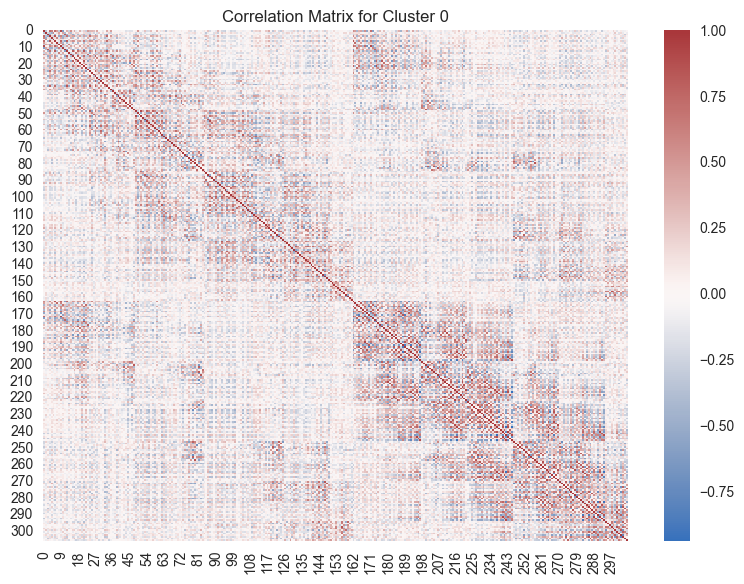

In [78]:
# ------------------- STEP 3: Cluster-wise Correlation Matrices ------------------- #
cluster_corrs = {}
for clust_id in sorted(modes_df["kmeans_cluster"].unique()):
    cluster_signals = modes_df[modes_df["kmeans_cluster"] == clust_id]["signal"].tolist()
    n = len(cluster_signals)
    corr_mat = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            corr_mat[i, j], _ = pearsonr(cluster_signals[i], cluster_signals[j])
    cluster_corrs[clust_id] = corr_mat

# Show one example correlation matrix
example_cluster = sorted(cluster_corrs.keys())[0]
plt.figure(figsize=(8, 6))
sns.heatmap(cluster_corrs[example_cluster], cmap="vlag", center=0)
plt.title(f"Correlation Matrix for Cluster {example_cluster}")
plt.tight_layout()
plt.show()


In [ ]:
def compute_pairwise_correlations(pairs):
    corrs = []
    for sig1, sig2 in tqdm(pairs, desc="Computing correlations"):
        r, _ = pearsonr(sig1, sig2)
        corrs.append(r)
    return corrs

In [81]:
# === 1. Same Cluster (across channels) ===
same_cluster_pairs = []

for clust in modes_df["kmeans_cluster"].unique():
    df_clust = modes_df[modes_df["kmeans_cluster"] == clust]
    df_clust = df_clust.sort_values("channel")  # optional, for reproducibility
    signals = df_clust["signal"].tolist()
    channels = df_clust["channel"].tolist()

    # Only take cross-channel pairs
    for i in range(len(signals)):
        for j in range(i + 1, len(signals)):
            if channels[i] != channels[j]:  # Only different channels
                same_cluster_pairs.append((signals[i], signals[j]))

same_cluster_corrs = compute_pairwise_correlations(same_cluster_pairs)

Computing correlations: 100%|██████████| 209892/209892 [02:20<00:00, 1493.85it/s]


In [83]:
# === 2. Same Mode Index (across channels) ===
same_index_pairs = []

for mode_idx in range(6):  # Assuming 6 modes
    df_mode = modes_df[modes_df["mode"] == mode_idx]
    df_mode = df_mode.sort_values("channel")
    signals = df_mode["signal"].tolist()
    channels = df_mode["channel"].tolist()

    for i in range(len(signals)):
        for j in range(i + 1, len(signals)):
            if channels[i] != channels[j]:
                same_index_pairs.append((signals[i], signals[j]))

same_index_corrs = compute_pairwise_correlations(same_index_pairs)

Computing correlations: 100%|██████████| 233325/233325 [03:44<00:00, 1040.52it/s]


In [85]:
import random

# === 3. Random Mode Pairs (Baseline) ===
random_pairs = []

all_signals = modes_df["signal"].tolist()
n_random = min(len(same_cluster_pairs), len(same_index_pairs))  # same size for fair comparison

for _ in range(n_random):
    sig1, sig2 = random.sample(all_signals, 2)
    random_pairs.append((sig1, sig2))

random_corrs = compute_pairwise_correlations(random_pairs)

Computing correlations: 100%|██████████| 209892/209892 [02:29<00:00, 1405.61it/s]


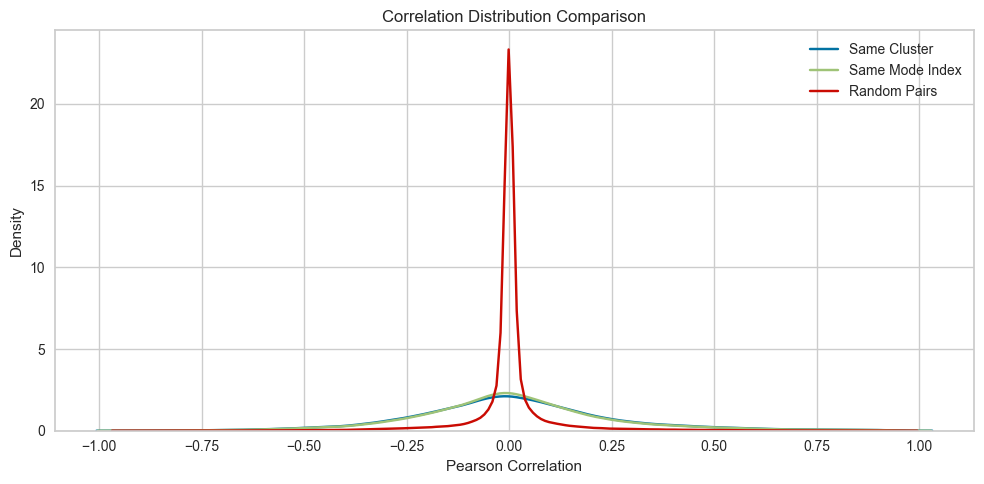

In [86]:
# === Optional: Save or plot the results ===

plt.figure(figsize=(10, 5))
sns.kdeplot(same_cluster_corrs, label="Same Cluster")
sns.kdeplot(same_index_corrs, label="Same Mode Index")
sns.kdeplot(random_corrs, label="Random Pairs")
plt.xlabel("Pearson Correlation")
plt.ylabel("Density")
plt.title("Correlation Distribution Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# clusteriser dnas une meme bande de fréquence (peak frequency)
# Pour chaque capteur 6 modes : est ce que les modes qui sont dans le meme cluster sont corrélés à traveers les capteurs + que des modes qui appartiennent à diff clusters (une matrice de corrélation apr cluster )
# Trouver le moyen de montrer que les modes via leur index appartienent à un cluster 
# REgarder par cluster de mode la corrélation entre les modes 

* Kmeans and dbscan improvment

## 4. MFA

Processing signal: meg_channel_0


<Figure size 800x400 with 0 Axes>

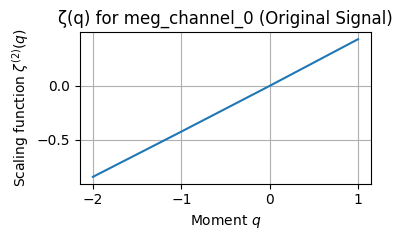

<Figure size 800x400 with 0 Axes>

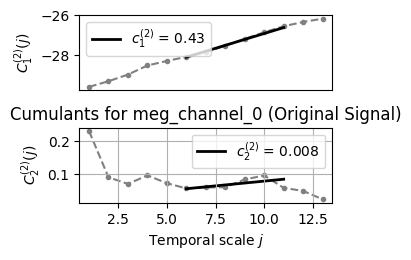

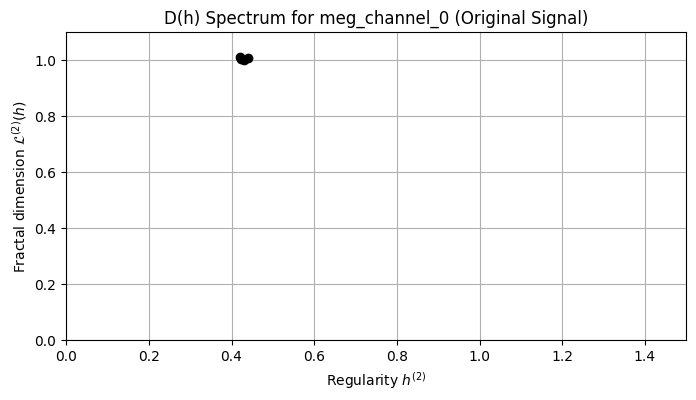

Processing signal: meg_channel_1


<Figure size 800x400 with 0 Axes>

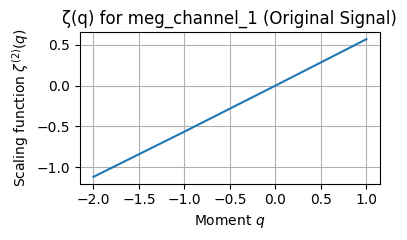

<Figure size 800x400 with 0 Axes>

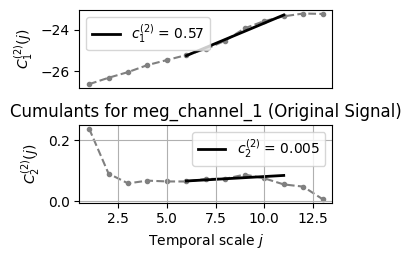

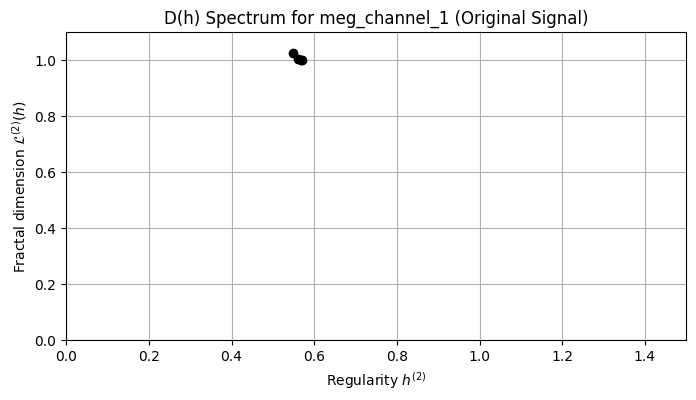

Processing signal: meg_channel_2


<Figure size 800x400 with 0 Axes>

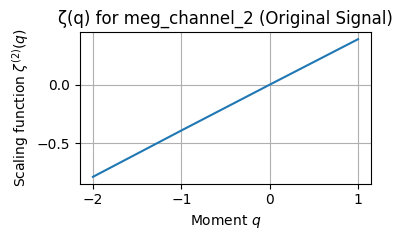

<Figure size 800x400 with 0 Axes>

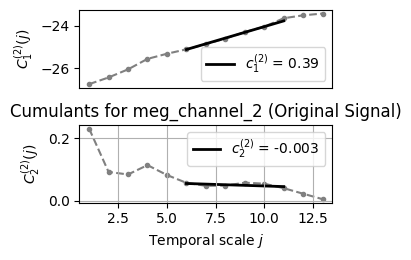

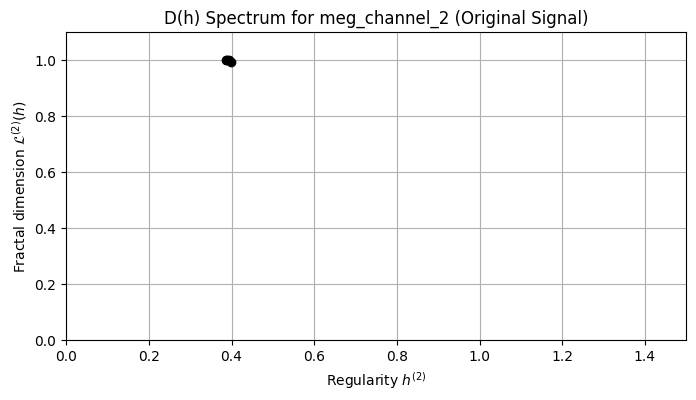

Processing signal: meg_channel_3


<Figure size 800x400 with 0 Axes>

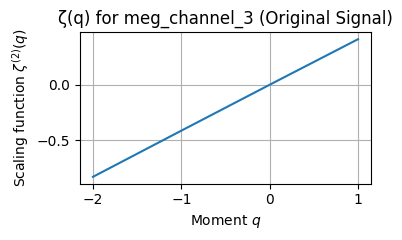

<Figure size 800x400 with 0 Axes>

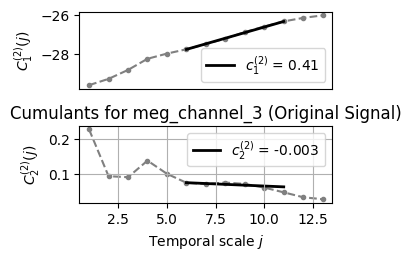

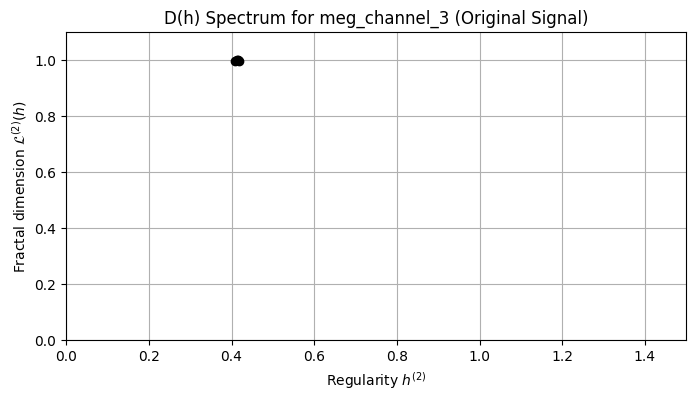

Processing signal: meg_channel_4


<Figure size 800x400 with 0 Axes>

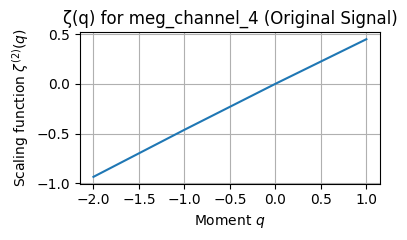

<Figure size 800x400 with 0 Axes>

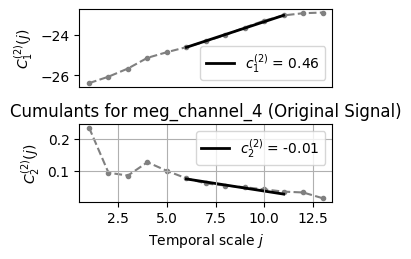

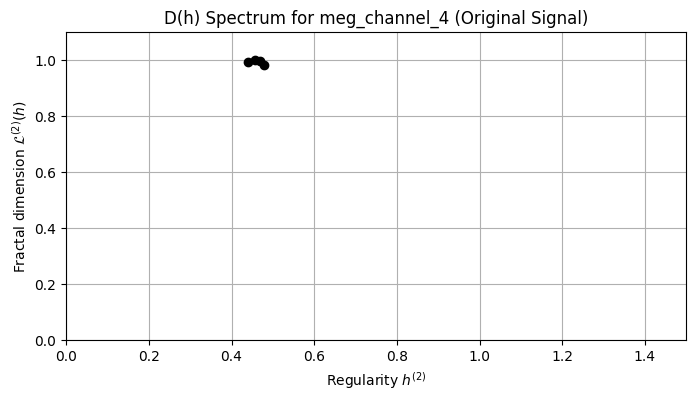

Processing signal: meg_channel_5


<Figure size 800x400 with 0 Axes>

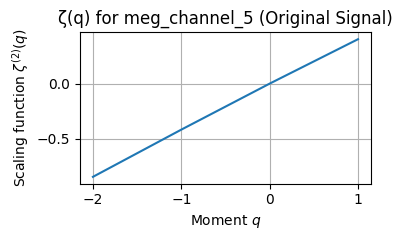

<Figure size 800x400 with 0 Axes>

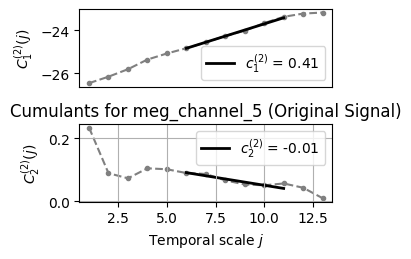

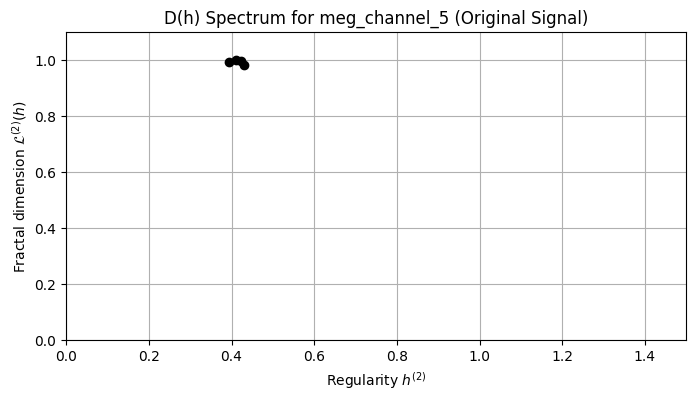

Processing signal: meg_channel_6


<Figure size 800x400 with 0 Axes>

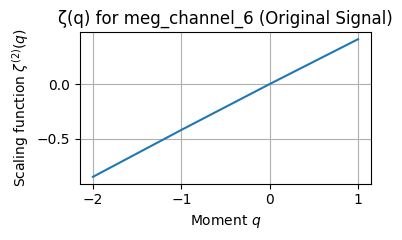

<Figure size 800x400 with 0 Axes>

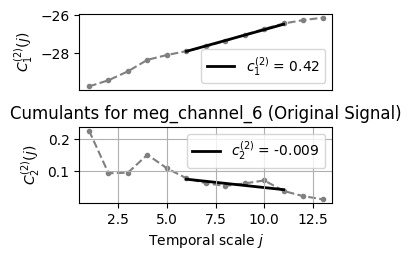

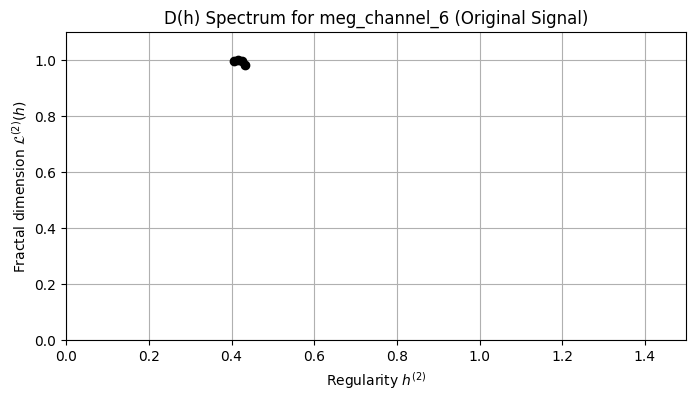

Processing signal: meg_channel_7


<Figure size 800x400 with 0 Axes>

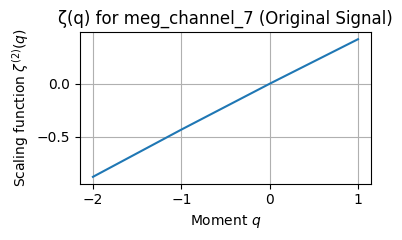

<Figure size 800x400 with 0 Axes>

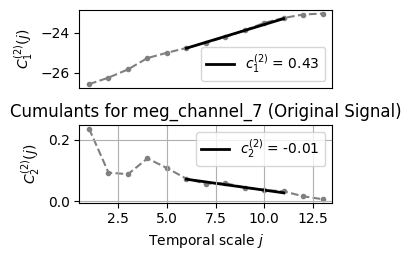

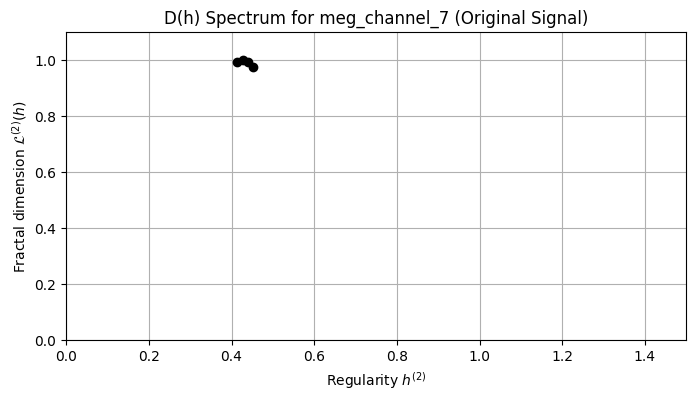

Processing signal: meg_channel_8


<Figure size 800x400 with 0 Axes>

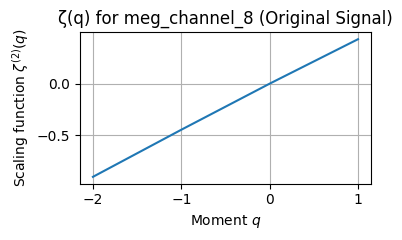

<Figure size 800x400 with 0 Axes>

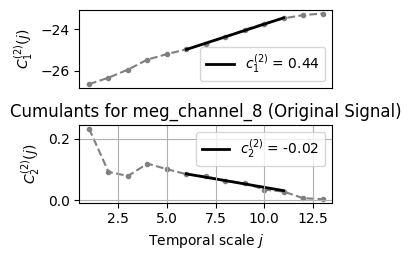

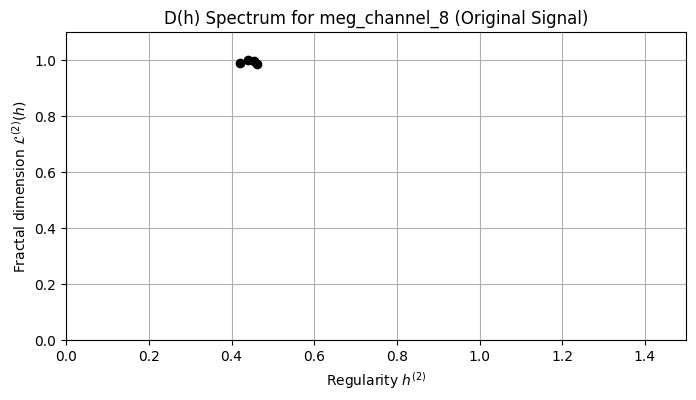

Processing signal: meg_channel_9


<Figure size 800x400 with 0 Axes>

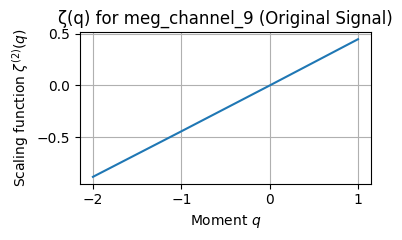

<Figure size 800x400 with 0 Axes>

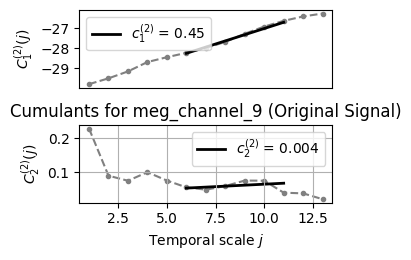

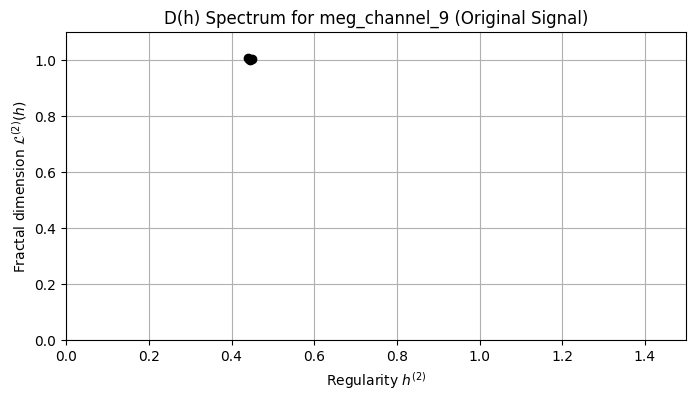

In [ ]:
scaling_ranges = [(6, 11)]
q_vals = np.arange(-2, 2)
summary_records = []
methods = ["VMD"]


signal_list = [data_matrix[ch_idx, :] for ch_idx in range(n_channels_to_process)]
signal_names = [f"meg_channel_{ch_idx}" for ch_idx in range(n_channels_to_process)]


for signal, name in zip(signal_list, signal_names):
    print(f"Processing signal: {name}")

    # MFA on original signal
    pwt_signal = compute_mfa(signal, scaling_ranges, q_vals)
    plot_mfa(pwt_signal, ch_label=f"{name} (Original Signal)")
    summary_records.append({
        "Signal": name,
        "Mode": "Original",
        "Log-cumulant 1": pwt_signal.cumulants.values[0],
        "Log-cumulant 2": pwt_signal.cumulants.values[1]

    })

    for method in methods:
        modes_path = os.path.join(output_base, name, method, "modes", f"{name}_modes.npy")
        if not os.path.exists(modes_path):
            print(f"Modes not found for {name} / {method} at {modes_path}")
            continue

        modes = np.load(modes_path)
        print(f"Loaded modes shape: {modes.shape} for {name} / {method}")

        for idx, mode in enumerate(modes):
            pwt_mode = compute_mfa(mode, scaling_ranges, q_vals)
            #plot_mfa(pwt_mode, ch_label=f"{name} | {method} Mode {idx}")
            summary_records.append({
                "Signal": name,
                "Mode": f"{method} Mode {idx}",
                "Log-cumulant 1": pwt_mode.cumulants.values[0],
                "Log-cumulant 2": pwt_mode.cumulants.values[1]
            })

summary_df = pd.DataFrame(summary_records)
summary_df.to_csv(os.path.join(output_base, "mfa_log_cumulants_summary.csv"), index=False)


In [103]:
summary_df['C1_flat'] = summary_df['Log-cumulant 1'].apply(lambda arr: arr.flatten())
summary_df['C2_flat'] = summary_df['Log-cumulant 2'].apply(lambda arr: arr.flatten())

# Check the new columns
summary_df

Signal      Mode                                     Log-cumulant 1  \
0  meg_channel_0  Original  [[[-29.602716263113127]], [[-29.31714420502243...   
1  meg_channel_1  Original  [[[-26.632769042210377]], [[-26.32331016613688...   
2  meg_channel_2  Original  [[[-26.754338789383926]], [[-26.43815269437106...   
3  meg_channel_3  Original  [[[-29.600312825628283]], [[-29.27875497000801...   
4  meg_channel_4  Original  [[[-26.391888594459683]], [[-26.07152800240672...   
5  meg_channel_5  Original  [[[-26.456191512475694]], [[-26.15505306581282...   
6  meg_channel_6  Original  [[[-29.778825093468583]], [[-29.45228477191572...   
7  meg_channel_7  Original  [[[-26.57710102709813]], [[-26.25151113276623]...   
8  meg_channel_8  Original  [[[-26.64754944140002]], [[-26.334243647534766...   
9  meg_channel_9  Original  [[[-29.787243608197624]], [[-29.49705786568036...   

                                      Log-cumulant 2  \
0  [[[0.23107844912306064]], [[0.0905390461256274...   
1  [[[0.2380243922268619]], [[0.09043441583366985...   
2  [[[0.23160975464213607]], [[0.0923626449457515...   
3  [[[0.22677845672797048]], [[0.0932712993721907...   
4  [[[0.2359528943073883]], [[0.09367060402428251...   
5  [[[0.234499896149714]], [[0.08924672360114982]...   
6  [[[0.2273296678171164]], [[0.09327419226201528...   
7  [[[0.2359377924033197]], [[0.09337817495134004...   
8  [[[0.23286342051142128]], [[0.0918628190031540...   
9  [[[0.2285977707517759]], [[0.08930925421066149...   

                                             C1_flat  \
0  [-29.602716263113127, -29.317144205022434, -28...   
1  [-26.632769042210377, -26.32331016613688, -26....   
2  [-26.754338789383926, -26.43815269437106, -26....   
3  [-29.600312825628283, -29.27875497000801, -28....   
4  [-26.391888594459683, -26.07152800240672, -25....   
5  [-26.456191512475694, -26.155053065812826, -25...   
6  [-29.778825093468583, -29.45228477191572, -28....   
7  [-26.57710102709813, -26.25151113276623, -25.8...   
8  [-26.64754944140002, -26.334243647534766, -25....   
9  [-29.787243608197624, -29.497057865680365, -29...   

                                             C2_flat  
0  [0.23107844912306064, 0.09053904612562746, 0.0...  
1  [0.2380243922268619, 0.09043441583366985, 0.05...  
2  [0.23160975464213607, 0.09236264494575153, 0.0...  
3  [0.22677845672797048, 0.0932712993721907, 0.09...  
4  [0.2359528943073883, 0.09367060402428251, 0.08...  
5  [0.234499896149714, 0.08924672360114982, 0.072...  
6  [0.2273296678171164, 0.09327419226201528, 0.09...  
7  [0.2359377924033197, 0.09337817495134004, 0.08...  
8  [0.23286342051142128, 0.09186281900315407, 0.0...  
9  [0.2285977707517759, 0.08930925421066149, 0.07...